In [49]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from plotly.subplots import make_subplots
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import pytz

In [2]:
def plot_candlestick(df, anomaly, title):
    
    # fig = go.Figure()
    fig = make_subplots(specs=[[{'secondary_y': True}]])
    
    fig.add_trace(
        go.Candlestick(
            x=df['datetime'],
            open=df['open'],
            low=df['low'],
            high=df['high'],
            close=df['close'],
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Bar(
            x=df['datetime'],
            y=df['volume'],
            opacity=0.5,
            showlegend=False,
            name='Volume'
        ),
        secondary_y=True
    )
    
    for idx in anomaly:
        if idx == df.index[0]:
            x0 = df.loc[idx, 'datetime']
        else:
            x0 = df.loc[(idx-1), 'datetime']
        
        if idx == df.index[-1]:
            x1 = df.loc[df.index.max, 'datetime']
        else:
            x1 = df.loc[(idx+1), 'datetime']

        fig.add_vrect(
            x0=x0,
            x1=x1,
            fillcolor='salmon',
            opacity=0.2,
            line_width=0,
        )
    
    fig.update_layout(
        title=f'{title}',
        xaxis_title='Datetime',
        yaxis_title='Price ($)',
        xaxis_rangeslider_visible=False,
        width=2000,
        height=500,
        # template='plotly_dark',
        template='plotly'
    )
    
    fig.update_xaxes(rangebreaks = [{'bounds': ['sat', 'mon']}])
    
    fig.show()

In [24]:
def scatter_plot(df, x, y, title=''):
    df.plot.scatter(x=x, y=y, title=title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [2]:
df_wti = pd.read_csv(
    './data/backtestmarket/cl-15m.csv',
    sep=';', header=0,
    names=['date', 'time', 'open', 'high', 'low', 'close', 'volume']
)

df_wti['date'] = pd.to_datetime(df_wti['date'], format='%d/%m/%Y')
df_wti['date'] = df_wti['date'].dt.strftime('%m-%d-%Y')

df_wti['datetime'] = pd.to_datetime(df_wti['date'] + ' ' + df_wti['time'])

df_wti['datetime'] = df_wti['datetime'].dt.tz_localize('Etc/GMT+6')
ny_tz = pytz.timezone('America/New_York')
df_wti['datetime'] = df_wti['datetime'].dt.tz_convert(ny_tz)
df_wti['datetime'] = pd.to_datetime(df_wti['datetime'])
df_wti['date'] = df_wti['datetime'].dt.strftime('%Y-%m-%d')
df_wti['time'] = df_wti['datetime'].dt.strftime('%H%M')
df_wti['day'] = df_wti['datetime'].dt.strftime('%A')

# take only wednesday data for 10 years
df_wti = df_wti[(df_wti['datetime'].dt.hour >= 9) & (df_wti['datetime'].dt.hour < 16)]
df = df_wti[(df_wti['datetime'].dt.weekday == 2) & (df_wti['datetime'].dt.year >= 2010) & (df_wti['datetime'].dt.year <= 2019)]
df.head()

,date,time,open,high,low,close,volume,datetime,day
65918,2010-01-06,0900,81.84,81.92,81.67,81.80,5818,2010-01-06 09:00:00-05:00,Wednesday
65919,2010-01-06,0915,81.80,81.92,81.67,81.76,3187,2010-01-06 09:15:00-05:00,Wednesday
65920,2010-01-06,0930,81.76,81.90,81.67,81.73,4522,2010-01-06 09:30:00-05:00,Wednesday
65921,2010-01-06,0945,81.75,81.87,81.62,81.79,5741,2010-01-06 09:45:00-05:00,Wednesday
65922,2010-01-06,1000,81.79,81.97,81.74,81.87,4907,2010-01-06 10:00:00-05:00,Wednesday


- Check for anomalies that happen between 1030 and 1130
- Check how long it takes to settle back to historical 30 day mean

In [36]:
df_result = []
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    # check for volume anomaly, use sma over the past hour
    sma = df_day['volume'].rolling(window=4).mean()
    threshold = sma.std() * 2
    df_anomaly = df_day[df_day['volume'] > (sma + threshold)]
    df_anomaly = df_anomaly[
        (df_anomaly['datetime'].dt.time >= pd.to_datetime('10:30').time()) &
        (df_anomaly['datetime'].dt.time <= pd.to_datetime('11:30').time())
    ]
    
    # skip if no anomalous volume spikes
    if df_anomaly.shape[0] == 0:
        continue
    
    # let's consider only the earliest anomaly if there are multiple ones between 1030 and 1130
    df_anomaly = df_anomaly.iloc[0]

    # get data from past 30 days to compute mean / std
    date_30_days_ago = day.date() - pd.Timedelta(days=30)
    df_30 = df_wti[(df_wti['datetime'].dt.date >= date_30_days_ago) & (df_wti['datetime'].dt.date <= day.date())]
    
    # compute mean / std of close price with data from past 30 days
    mean = df_30['close'].mean()
    std = df_30['close'].std()

    # price at volume spike, compute z score
    price = df_anomaly['close']
    z_score = (price - mean) / std

    # track when it settles back to mean, allow +- 0.2 difference
    df_future = df_wti[(df_wti['datetime'] > df_anomaly['datetime'])]
    upper = mean + 0.1
    lower = mean - 0.1
    df_settle = df_future[(df_future['close'] >= lower) & (df_future['close'] <= upper)].iloc[0]

    # record some stats
    time_revert_mean = df_settle['datetime'] - df_anomaly['datetime']
    df_anomaly['z_score'] = z_score
    df_anomaly['past_30_mean'] = mean
    df_anomaly['past_30_std'] = std
    df_anomaly['settled_price'] = df_settle['close']
    # df_anomaly['settled_datetime'] = df_settle['datetime']
    df_anomaly['delta'] = time_revert_mean.total_seconds() / 3600
    df_result.append(df_anomaly)

df_result = pd.DataFrame(df_result)
df_result.head(3)

,date,time,open,high,low,close,volume,datetime,day,z_score,past_30_mean,past_30_std,settled_price,delta
65924,2010-01-06,1030,82.28,82.32,80.85,81.24,35422,2010-01-06 10:30:00-05:00,Wednesday,1.453802,75.398273,4.018240,75.38,384.75
66390,2010-01-13,1030,79.32,79.32,78.37,78.87,27764,2010-01-13 10:30:00-05:00,Wednesday,0.261756,77.793454,4.112779,77.74,143.75
67300,2010-01-27,1030,74.58,74.73,73.90,74.15,28633,2010-01-27 10:30:00-05:00,Wednesday,-1.809115,79.046479,2.706560,79.05,531.75


In [37]:
df_result.describe()

,open,high,low,close,volume,z_score,past_30_mean,past_30_std,settled_price,delta
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,71.638186,71.972000,71.248023,71.600977,33404.962791,0.047806,71.701429,2.216237,71.694977,4955.902326
std,21.854170,21.833449,21.858836,21.861605,22545.836904,1.342414,21.845159,1.061619,21.844960,13030.424318
min,28.090000,29.220000,27.860000,28.030000,759.000000,-3.204417,30.423613,0.551231,30.480000,0.250000
25%,52.057500,52.295000,51.512500,51.792500,16347.250000,-1.122011,51.274768,1.509076,51.220000,50.500000
50%,67.865000,68.235000,67.550000,67.930000,26082.000000,0.127823,69.509316,2.025121,69.525000,385.000000
75%,93.087500,93.247500,92.732500,92.897500,49632.750000,1.183587,93.248058,2.620267,93.250000,2329.250000
max,111.350000,111.390000,110.710000,111.360000,129668.000000,3.223338,110.142484,7.290180,110.230000,68066.250000


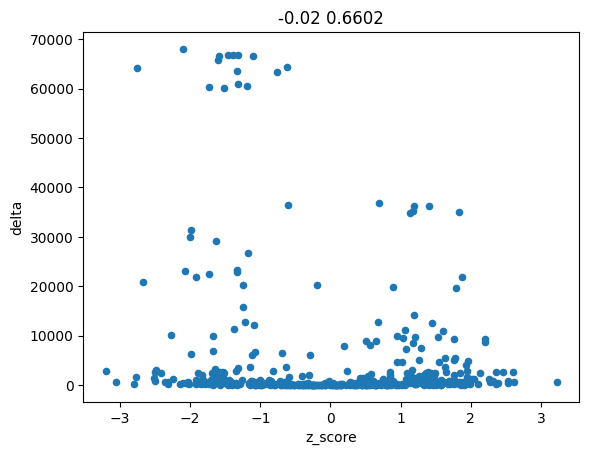

In [40]:
df_result['log_delta'] = np.log(df_result['delta'])
correlation, pvalue = spearmanr(df_result['z_score'], df_result['delta'])

scatter_plot(df_result, 'z_score', 'delta', f'{correlation:.2f} {pvalue:.4f}')

In [50]:
df_result[df_result['z_score'].abs() >= 1.5].to_csv('./outputs/wednesday_anomaly.csv', index=False)

- z score of price spike (compared to mean of last hour)
- correlation between z score and price 2 hours later

In [41]:
# correlation with 2 hours later

df_result = []
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    # check for volume anomaly, use sma over the past hour
    sma = df_day['volume'].rolling(window=4).mean()
    threshold = sma.std() * 2
    df_anomaly = df_day[df_day['volume'] > (sma + threshold)]
    df_anomaly = df_anomaly[
        (df_anomaly['datetime'].dt.time >= pd.to_datetime('10:30').time()) &
        (df_anomaly['datetime'].dt.time <= pd.to_datetime('11:30').time())
    ]
    
    # skip if no anomalous volume spikes
    if df_anomaly.shape[0] == 0:
        continue
    
    # let's consider only the earliest anomaly if there are multiple ones between 1030 and 1130
    df_anomaly = df_anomaly.iloc[0]

    # compute mean / std of past hour
    time_past = df_anomaly['datetime'] - pd.Timedelta(hours=1)
    df_past = df_wti[(df_wti['datetime'] < df_anomaly['datetime']) & (df_wti['datetime'] >= time_past)]

    # get data from past next 2 hours to compute mean / std
    time_next = df_anomaly['datetime'] + pd.Timedelta(hours=2)
    df_next = df_wti[df_wti['datetime'] == time_next]
    price_next = df_next['close'].values[0]

    # compute mean / std of close price with data from past hour
    mean_past = df_past['close'].mean()
    std_past = df_past['close'].std()

    # price at volume spike, compute z score
    price = df_anomaly['close']
    z_score = (price - mean_past) / std_past

    # record some stats
    time_revert_mean = df_settle['datetime'] - df_anomaly['datetime']
    df_anomaly['z_score'] = z_score
    df_anomaly['price_2_hrs'] = price_next
    df_result.append(df_anomaly)

df_result = pd.DataFrame(df_result)
df_result.head(3)

,date,time,open,high,low,close,volume,datetime,day,z_score,price_2_hrs
65924,2010-01-06,1030,82.28,82.32,80.85,81.24,35422,2010-01-06 10:30:00-05:00,Wednesday,-2.566472,82.91
66390,2010-01-13,1030,79.32,79.32,78.37,78.87,27764,2010-01-13 10:30:00-05:00,Wednesday,-2.429735,80.19
67300,2010-01-27,1030,74.58,74.73,73.90,74.15,28633,2010-01-27 10:30:00-05:00,Wednesday,-2.891874,74.43


In [42]:
df_result.describe()

,open,high,low,close,volume,z_score,price_2_hrs
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,71.638186,71.972000,71.248023,71.600977,33404.962791,-0.837990,71.632953
std,21.854170,21.833449,21.858836,21.861605,22545.836904,7.826466,21.872107
min,28.090000,29.220000,27.860000,28.030000,759.000000,-34.833333,28.020000
25%,52.057500,52.295000,51.512500,51.792500,16347.250000,-3.854386,51.822500
50%,67.865000,68.235000,67.550000,67.930000,26082.000000,-0.377990,68.185000
75%,93.087500,93.247500,92.732500,92.897500,49632.750000,3.197373,92.862500
max,111.350000,111.390000,110.710000,111.360000,129668.000000,37.328178,112.530000


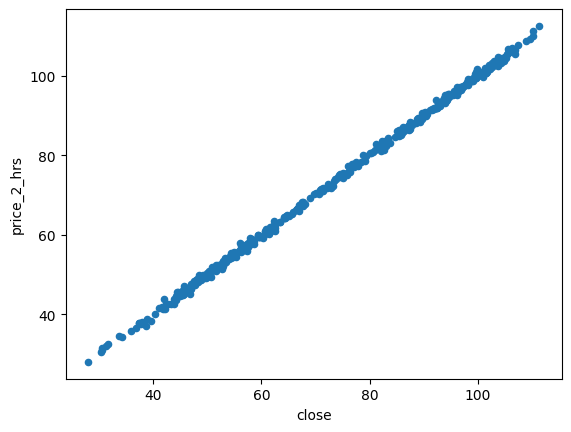

In [57]:
scatter_plot(df_result, 'close', 'price_2_hrs')

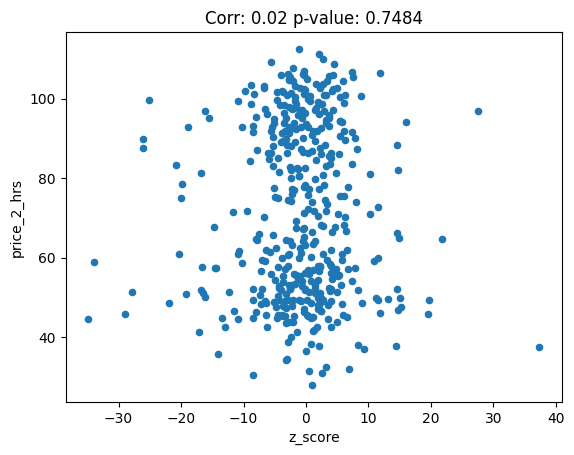

In [44]:
correlation, pvalue = spearmanr(df_result['z_score'], df_result['price_2_hrs'])

scatter_plot(df_result, 'z_score', 'price_2_hrs', f'Corr: {correlation:.2f} p-value: {pvalue:.4f}')

In [56]:
# X = df_result['z_score'].values.reshape(-1, 1)
X = df_result[['close']].values.reshape(-1, 1)
y = df_result['price_2_hrs'].values.reshape(-1, 1)

model = KernelRidge(kernel='rbf', alpha=0.1)
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
r2

0.996981830139929

In [3]:
df_result = []
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    # check for volume anomaly, use sma over the past hour
    sma = df_day['volume'].rolling(window=4).mean()
    threshold = sma.std() * 2
    df_anomaly = df_day[df_day['volume'] > (sma + threshold)]
    df_anomaly = df_anomaly[
        (df_anomaly['datetime'].dt.time >= pd.to_datetime('10:30').time()) &
        (df_anomaly['datetime'].dt.time <= pd.to_datetime('11:30').time())
    ]
    
    # skip if no anomalous volume spikes
    if df_anomaly.shape[0] == 0:
        continue
    
    # let's consider only the earliest anomaly if there are multiple ones between 1030 and 1130
    df_anomaly = df_anomaly.iloc[0]

    # compute mean / std of past hour
    time_past = df_anomaly['datetime'] - pd.Timedelta(hours=1)
    df_past = df_wti[(df_wti['datetime'] < df_anomaly['datetime']) & (df_wti['datetime'] >= time_past)]

    # get data from past next 2 hours to compute mean / std
    time_next = df_anomaly['datetime'] + pd.Timedelta(hours=2)
    df_next = df_wti[(df_wti['datetime'] > df_anomaly['datetime']) & (df_wti['datetime'] <= time_next)]
    
    # compute mean / std of close price with data from past 30 days
    mean_past = df_past['close'].mean()
    std_past = df_past['close'].std()

    # price at volume spike, compute z score
    price = df_anomaly['close']
    z_score = (price - mean_past) / std_past

    mean_future = df_next['close'].mean()
    std_future = df_next['close'].std() 

    # track when it settles back to mean, allow +- 0.2 difference
    df_future = df_wti[(df_wti['datetime'] > df_anomaly['datetime'])]
    upper = mean_future + 0.1
    lower = mean_future - 0.1
    df_settle = df_future[(df_future['close'] >= lower) & (df_future['close'] <= upper)].iloc[0]

    # record some stats
    time_revert_mean = df_settle['datetime'] - df_anomaly['datetime']
    df_anomaly['z_score'] = z_score
    df_anomaly['2_hr_mean'] = mean_future
    # df_anomaly['2_hr_std'] = std
    df_anomaly['settled_price'] = df_settle['close']
    df_anomaly['settled_datetime'] = df_settle['datetime']
    df_anomaly['delta'] = time_revert_mean.total_seconds() / 3600
    df_result.append(df_anomaly)

df_result = pd.DataFrame(df_result)
df_result.head(3)

,date,time,open,high,low,close,volume,datetime,day,z_score,2_hr_mean,settled_price,settled_datetime,delta
65924,2010-01-06,1030,82.28,82.32,80.85,81.24,35422,2010-01-06 10:30:00-05:00,Wednesday,-2.566472,82.42875,82.38,2010-01-06 11:15:00-05:00,0.75
66390,2010-01-13,1030,79.32,79.32,78.37,78.87,27764,2010-01-13 10:30:00-05:00,Wednesday,-2.429735,79.58500,79.67,2010-01-13 11:30:00-05:00,1.00
67300,2010-01-27,1030,74.58,74.73,73.90,74.15,28633,2010-01-27 10:30:00-05:00,Wednesday,-2.891874,74.66375,74.60,2010-01-27 10:45:00-05:00,0.25


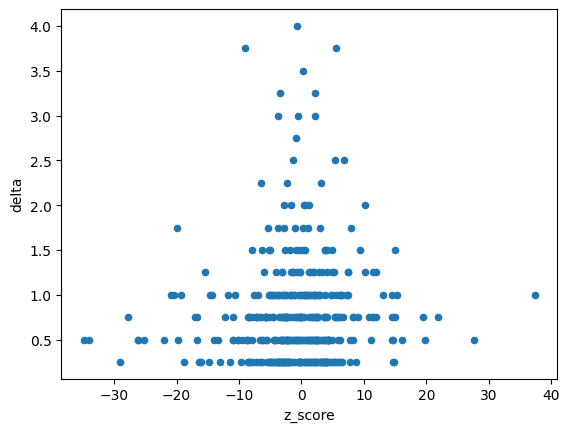

In [8]:
df_result[df_result['delta'] < 5].plot.scatter(x='z_score', y='delta', title='')
plt.xlabel('z_score')
plt.ylabel('delta')
plt.show()